In [ ]:
# TA-Lib 설치 코드
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr
import scipy.stats as stats
import math
from sklearn.preprocessing import MinMaxScaler
import collections
import pandas as pd
from sklearn import datasets
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
from tqdm import tqdm
import matplotlib.pyplot as plt
%pylab inline
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier # 결정 트리
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier # 앙상블 

from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score,classification_report,confusion_matrix  # ROC곡선 그리기

from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV, cross_val_score  # 하이퍼파라미터 튜닝, 교차타당도

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3665    0  3665    0     0  13675      0 --:--:-- --:--:-- --:--:-- 13624
100  503k  100  503k    0     0   816k      0 --:--:-- --:--:-- --:--:--  816k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3673    0  3673    0     0  15831      0 --:--:-- --:--:-- --:--:-- 15831
100  406k  100  406k    0     0   670k      0 --:--:-- --:--:-- --:--:-- 3103k
Populating the interactive namespace from numpy and matplotlib


# 데이터 불러오기(original)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data/original_data.csv", index_col =['Date'], parse_dates=True)

In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,S&P500,SOX,VIX,KOSPI,log_return,CCI,MA5,MA10,MA20,MA60,MA20_ratio,MA60_ratio,MA20_volume,MA60_volumne,RASD5,RASD10,MACD,ATR,ub,middle,lb,MTM1,MTM3,ROC,WPR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-19,431000.0,434000.0,424500.0,424500.0,424500.0,504352,4405.799805,3235.870117,21.670000,3097.830078,-0.010545,-94.145759,431800.0,438500.0,439525.0,413150.000000,0.965815,1.027472,665965.15,779609.133333,5051.843593,5044.528400,1884.242572,12140.316581,456049.148995,439525.0,423000.851005,-4500.0,-12000.0,16.942149,-86.567164
2021-08-20,425000.0,432000.0,421000.0,422500.0,422500.0,587940,4441.669922,3256.500000,18.559999,3060.510010,-0.004723,-100.375738,428200.0,436500.0,438650.0,414225.000000,0.963182,1.019977,643568.05,773346.983333,5534.340346,5057.375240,727.170577,12058.865397,456758.285396,438650.0,420541.714604,-2000.0,-6000.0,18.016760,-92.537313
2021-08-23,428000.0,436000.0,423500.0,429500.0,429500.0,515679,4479.529785,3342.010010,17.150000,3090.209961,0.016432,-55.850234,426800.0,435000.0,437525.0,415416.666667,0.981658,1.033902,614650.70,774623.100000,5267.825466,4714.171343,370.750404,12161.803583,454959.090168,437525.0,420090.909832,7000.0,500.0,19.972067,-71.641791
2021-08-24,435000.0,439000.0,431500.0,437500.0,437500.0,546884,4486.229980,3345.392822,17.219999,NaN,0.018455,-4.754008,428600.0,434000.0,436800.0,416666.666667,1.001603,1.050000,599231.05,777119.200000,5007.206967,4495.087997,725.455392,11971.674755,452922.654868,436800.0,420677.345132,8000.0,13000.0,20.689655,-47.761194
2021-08-25,434000.0,439000.0,432500.0,433000.0,433000.0,170243,NaN,NaN,NaN,3143.060059,-0.010339,-19.594203,429400.0,432650.0,435850.0,417766.666667,0.993461,1.036464,569861.30,773221.416667,4817.458343,4523.945382,636.116503,11580.840844,450444.862110,435850.0,421255.137890,-4500.0,10500.0,17.983651,-61.194030


In [ ]:
#df = df.drop(['MA20_volume', 'MA60_volumne'], axis = 1)
#df.columns
        
#df.columns

df = df.drop(['log_return', 'MTM1', 'MTM3'], axis = 1)

#diff = df['MA20_ratio']-df['MA60_ratio']
#df['golden'] = np.where(diff>0,1,-1)

In [ ]:
df.isnull().any()

Open            False
High            False
Low             False
Close           False
Adj Close       False
Volume          False
S&P500           True
SOX              True
VIX              True
KOSPI            True
CCI              True
MA5              True
MA10             True
MA20             True
MA60             True
MA20_ratio       True
MA60_ratio       True
MA20_volume      True
MA60_volumne     True
RASD5            True
RASD10           True
MACD             True
ATR              True
ub               True
middle           True
lb               True
ROC              True
WPR              True
dtype: bool

In [ ]:
df = df.dropna(axis=0)

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,S&P500,SOX,VIX,KOSPI,CCI,MA5,MA10,MA20,MA60,MA20_ratio,MA60_ratio,MA20_volume,MA60_volumne,RASD5,RASD10,MACD,ATR,ub,middle,lb,ROC,WPR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-03-31,7395.186035,7436.043457,7223.585449,7239.928223,7101.616211,1958030,1180.589966,416.989990,14.02,965.679993,77.408536,7277.516895,7039.726953,7114.904565,7271.660718,1.017572,0.995636,2085301.95,2.623862e+06,213.150136,158.625026,-12.354711,227.920020,7561.611597,7114.904565,6668.197534,3.023257,-28.155320
2005-04-01,7166.384766,7313.471680,7166.384766,7272.614258,7133.678711,1740199,1172.920044,411.220001,14.09,981.900024,63.909019,7288.957031,7082.218652,7119.398877,7277.108374,1.021521,0.999382,2074349.20,2.623312e+06,181.928256,147.849453,-0.317474,222.146227,7570.531720,7119.398877,6668.266034,4.705887,-22.772258
2005-04-04,7346.157227,7346.157227,7166.384766,7190.899414,7053.524414,1038979,1176.119995,409.420013,14.11,982.500000,56.086788,7256.271191,7110.001660,7120.624609,7280.513159,1.009869,0.987691,2047915.75,2.515946e+06,134.852992,141.939089,2.598465,219.119529,7572.394200,7120.624609,6668.855019,2.923979,-32.673255
2005-04-06,7174.556152,7517.758301,7174.556152,7444.214844,7302.000000,3884242,1184.069946,410.869995,13.15,988.000000,88.750882,7267.711230,7221.133740,7126.753198,7280.785539,1.044545,1.022447,1948668.10,2.425143e+06,52.904059,138.366320,26.772312,213.449135,7591.889648,7126.753198,6661.616748,0.662983,-8.333352
2005-04-07,7517.758301,7648.501953,7493.244141,7566.787109,7422.230957,2261525,1191.140015,418.970001,12.33,988.900024,136.064574,7333.083008,7305.299951,7140.236133,7282.283643,1.059739,1.039068,1919297.65,2.404644e+06,72.292447,142.721292,53.417980,212.794705,7638.779194,7140.236133,6641.693071,1.202186,-8.064523


In [ ]:
df.shape

(3908, 28)

# encoder로 특징 추출

In [ ]:
RASD5 = df['RASD5']
RASD5.head()

Date
2005-03-31    213.150136
2005-04-01    181.928256
2005-04-04    134.852992
2005-04-06     52.904059
2005-04-07     72.292447
Name: RASD5, dtype: float64

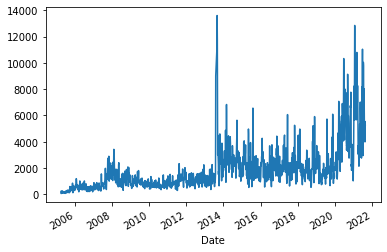

In [ ]:
RASD5.plot()

In [ ]:
RASD5.isnull()

Date
2005-03-31    False
2005-04-01    False
2005-04-04    False
2005-04-06    False
2005-04-07    False
              ...  
2021-08-17    False
2021-08-18    False
2021-08-19    False
2021-08-20    False
2021-08-23    False
Name: RASD5, Length: 3908, dtype: bool

In [ ]:
window_length = 10
encoding_dim = 3
scaler = MinMaxScaler()
x_train = np.array([scaler.fit_transform(RASD5.values[i-window_length:i].reshape(-1,1)) for i in range(window_length+1, len(RASD5))])

In [ ]:
# 훈련 데이터 형태
x_train.shape

(3897, 10, 1)

In [ ]:
# 훈련 데이터셋과 테스트 데이터셋 분할
test_samples = 200 # 아직도 이거 왜 나누는지 모르겠음
x_train = x_train[:-test_samples]
x_test = x_train[-test_samples:]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# 전체 데이터 중 테스트 데이터가 사용된 비중 계산
print("테스트 데이터 비중: {}%".format((test_samples/len(x_train))*100))

테스트 데이터 비중: 5.409791723018664%


In [ ]:
def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 20))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 66        
_________________________________________________________________
batch_normalization (BatchNo (None, 6)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 24        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                70    

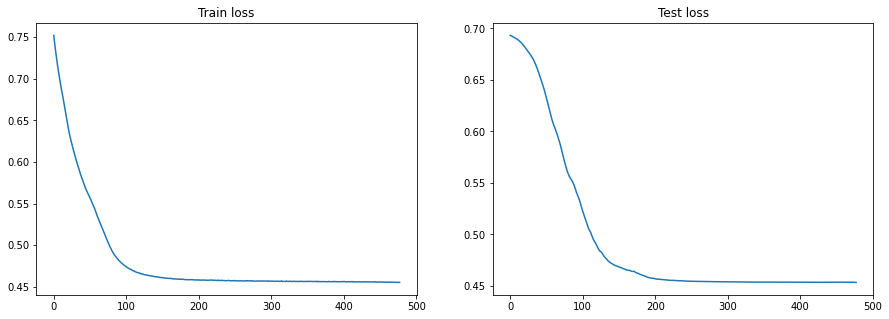

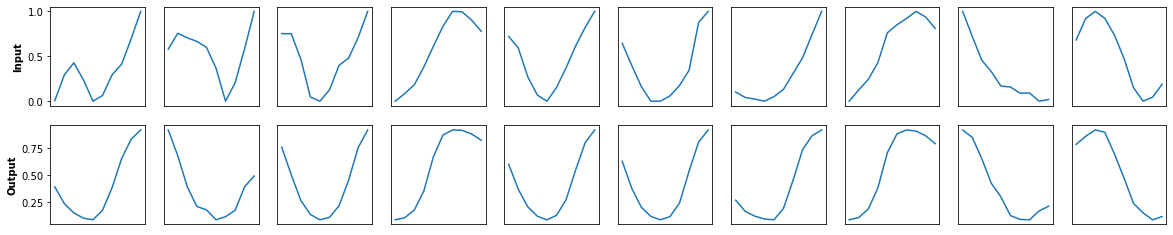

In [ ]:
from keras.callbacks import EarlyStopping
import tensorflow as tf
x_train_sample = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_sample = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

# early stopping 정의
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['acc'])
history = autoencoder.fit(x_train_sample, x_train_sample,
                epochs=500,
                batch_size=1024,
                shuffle=True,
                callbacks = [es],
                validation_data=(x_test_sample, x_test_sample))

decoded_stocks = autoencoder.predict(x_test_sample)
plot_history(history)
plot_examples(x_test_sample, decoded_stocks)

In [ ]:
decoded_stocks

array([[0.39485812, 0.23884141, 0.15279776, ..., 0.65533054, 0.8359107 ,
        0.92115116],
       [0.30552077, 0.18057433, 0.12184367, ..., 0.7240786 , 0.87689066,
        0.9446325 ],
       [0.13808891, 0.10174713, 0.10074836, ..., 0.8321675 , 0.9048823 ,
        0.94361305],
       ...,
       [0.0533312 , 0.09228903, 0.2137698 , ..., 0.8583288 , 0.76404417,
        0.59971553],
       [0.06651106, 0.13348368, 0.31972623, ..., 0.8096658 , 0.6199071 ,
        0.33936292],
       [0.15468794, 0.25653356, 0.44958547, ..., 0.6699035 , 0.44525552,
        0.19613805]], dtype=float32)

In [ ]:
compress_x_train = encoder.predict(x_train_sample)
compress_x_test = encoder.predict(x_test_sample)

In [ ]:
new_feature = np.concatenate([compress_x_train, compress_x_test])
tmp_df = pd.DataFrame(new_feature, columns = ['comp_fe1', 'comp_fe2', 'comp_fe3'])

In [ ]:
tmp_df.shape

(3897, 3)

In [ ]:
n_df = df.iloc[11:]
tmp_df.index = n_df.index

In [ ]:
tmp_df

,comp_fe1,comp_fe2,comp_fe3
Date,,,
2005-04-18,1.681837,1.525225,0.758490
2005-04-19,1.353903,0.914355,0.979622
2005-04-20,1.093739,0.789915,1.402744
2005-04-21,1.016869,1.193853,1.830824
2005-04-22,0.881886,1.367229,2.213983
...,...,...,...
2021-08-17,0.939722,1.166774,1.963049
2021-08-18,0.760159,0.567948,1.902353
2021-08-19,0.912804,0.252819,1.387182


In [ ]:
df = pd.merge(df, tmp_df,left_index=True, right_index=True,how='inner')

In [ ]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'S&P500', 'SOX',
       'VIX', 'KOSPI', 'CCI', 'MA5', 'MA10', 'MA20', 'MA60', 'MA20_ratio',
       'MA60_ratio', 'MA20_volume', 'MA60_volumne', 'RASD5', 'RASD10', 'MACD',
       'ATR', 'ub', 'middle', 'lb', 'ROC', 'WPR', 'comp_fe1', 'comp_fe2',
       'comp_fe3'],
      dtype='object')

In [ ]:
df = df.drop(columns = ['RASD5'], axis = 1)

# feature

In [ ]:
df['next_price'] = df['Close'].shift(-90) # 90일 후 예상

# 라벨링

In [ ]:
diffs = df['next_price']-df['Close']
df['label'] = np.where(diffs>0,1,0)

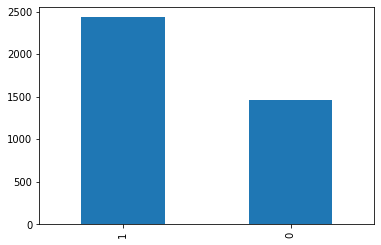

In [ ]:
df['label'].value_counts().plot.bar()

In [ ]:
# 예측기간 2011-01-03 ~ 2020-12-31
df = df.loc['2011-01-03':'2020-12-31']
df.head()


,Open,High,Low,Close,Adj Close,Volume,S&P500,SOX,VIX,KOSPI,CCI,MA5,MA10,MA20,MA60,MA20_ratio,MA60_ratio,MA20_volume,MA60_volumne,RASD10,MACD,ATR,ub,middle,lb,ROC,WPR,comp_fe1,comp_fe2,comp_fe3,next_price,label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-03,56138.042969,56260.617188,53931.746094,54299.460938,53262.128906,620732,1271.869995,415.049988,17.610001,2070.080078,154.460116,53122.768750,52031.876563,49623.333984,48967.572917,1.094232,1.108886,743832.35,783104.850000,1151.430055,1620.414990,1677.743121,55274.042427,49623.333984,43972.625542,4.481133,-20.512837,1.277800,0.439901,0.802157,47557.992188,0
2011-01-04,54789.750000,55280.039062,53196.312500,54299.460938,53262.128906,622788,1270.199951,415.579987,17.379999,2085.139893,110.166821,53907.230469,52313.792578,50058.465039,48998.215951,1.084721,1.108193,742153.15,783491.083333,1117.982020,1703.556372,1706.741938,55742.112759,50058.465039,44374.817319,3.504673,-20.512837,1.325723,0.881929,1.012423,46332.273438,0
2011-01-05,53686.601562,55770.328125,53686.601562,54544.605469,53502.585938,764757,1276.560059,417.089996,17.020000,2082.550049,104.650453,54446.547656,52742.794922,50475.210352,49034.987565,1.080622,1.112361,750439.50,786111.033333,1046.805197,1768.837573,1733.669411,56191.121155,50475.210352,44759.299548,4.215453,-18.918935,1.231304,1.435590,1.577776,46209.699219,0
2011-01-06,55034.894531,55280.039062,53809.171875,54299.460938,53262.128906,779263,1273.849976,424.769989,17.400000,2077.610107,80.880012,54618.148438,53049.225391,50861.312500,49088.102148,1.067599,1.106163,752022.65,793468.600000,989.796333,1780.270430,1714.897824,56514.785614,50861.312500,45207.839386,6.235010,-25.806465,1.054813,1.487110,1.958298,47067.703125,0
2011-01-07,54299.460938,55770.328125,54299.460938,55157.464844,54103.734375,826631,1271.500000,425.760010,17.139999,2086.199951,89.220552,54520.090625,53416.941797,51259.671875,49165.731120,1.076040,1.121868,752334.90,787604.433333,956.362888,1837.384571,1697.467064,56945.011148,51259.671875,45574.332602,9.223294,-15.789515,0.937681,1.203010,1.991959,46332.273438,0


In [ ]:
X = df.drop(['next_price','label'], axis=1)
y = df['label']

y.shape

(2361,)

In [ ]:
X.shape

(2361, 30)

# 전처리

In [ ]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

le = LabelEncoder()        
y = le.fit_transform(y)   


In [ ]:
sum(y)/len(df) * 100

61.71113934773401

In [ ]:
X_scaled.shape

(2361, 30)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2, random_state=1234, stratify=y)

# 함수 정의

In [ ]:
def report(clf):
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    print('Random Forest Accuracy:', np.mean(y_pred == y_test))
    ax = plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), linewidths=0.5, fmt='.1f', annot=True)

In [ ]:
def feature_importance(clf):
    feature_importance = clf.feature_importances_
    # plot
    df_fi = pd.DataFrame({'columns':X.columns, 'importances':feature_importance})
    df_fi = df_fi[df_fi['importances'] > 0] # importance가 0이상인 것만 
    df_fi = df_fi.sort_values(by=['importances'], ascending=False)

    fig = plt.figure(figsize=(15,7))
    ax = sns.barplot(df_fi['columns'], df_fi['importances'])
    ax.set_xticklabels(df_fi['columns'], rotation=80, fontsize=13)
    plt.tight_layout()
    plt.show()

# 모델

In [ ]:
logistic = LogisticRegression(solver='liblinear',penalty='l2',C= 0.1,random_state=1)
tree = DecisionTreeClassifier(max_depth=4,criterion='entropy',random_state=1)
knn = KNeighborsClassifier(n_neighbors=41,p=2,metric='minkowski')

voting_estimators = [('logistic', logistic), ('tree', tree), ('knn', knn)]

voting = VotingClassifier(estimators = voting_estimators,voting='soft')

forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)

lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(tree_method='hist',random_state=41)

adaboost = AdaBoostClassifier(base_estimator=tree, 
                                n_estimators=100,
                                learning_rate = 0.01, 
                                random_state=42)

clf_labels = ['Random forest','Ada boost','XGB','LIGHTGBM']

all_clf = [ forest,adaboost,xgb,lgb]

In [ ]:
#forest.get_params()

In [ ]:
'''
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[700],
    'max_depth' : [4, 6, 8, 10], 
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
grid_cv = GridSearchCV(forest, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))
'''

"\nfrom sklearn.model_selection import GridSearchCV\n\nparams = {\n    'n_estimators':[700],\n    'max_depth' : [4, 6, 8, 10], \n    'min_samples_leaf' : [8, 12, 18],\n    'min_samples_split' : [8, 16, 20]\n}\n# RandomForestClassifier 객체 생성 후 GridSearchCV 수행\ngrid_cv = GridSearchCV(forest, param_grid=params, cv=2, n_jobs=-1)\ngrid_cv.fit(X_train, y_train)\n\nprint('최적 하이퍼 파라미터:\n', grid_cv.best_params_)\nprint('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))\n"

# AUC 검정

In [ ]:
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
  % (scores.mean(), scores.std(), label))

ROC AUC: 0.986 (+/- 0.007) [Random forest]
ROC AUC: 0.973 (+/- 0.017) [Ada boost]
ROC AUC: 0.977 (+/- 0.011) [XGB]
ROC AUC: 0.987 (+/- 0.008) [LIGHTGBM]


# ROC 커브

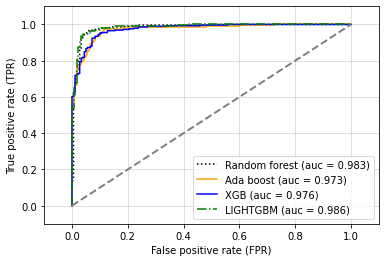

In [ ]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '-','solid','dashdot']
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):

  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                  y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr) # 교차검증 X
  plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %0.3f)' % (label, roc_auc))
  
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
          linestyle='--',
          color='gray',
          linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

# RF

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       181
           1       0.96      0.97      0.96       292

    accuracy                           0.96       473
   macro avg       0.95      0.95      0.95       473
weighted avg       0.96      0.96      0.96       473

Random Forest Accuracy: 0.9556025369978859


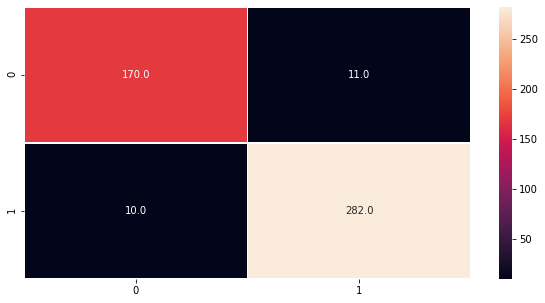

In [ ]:
report(forest)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


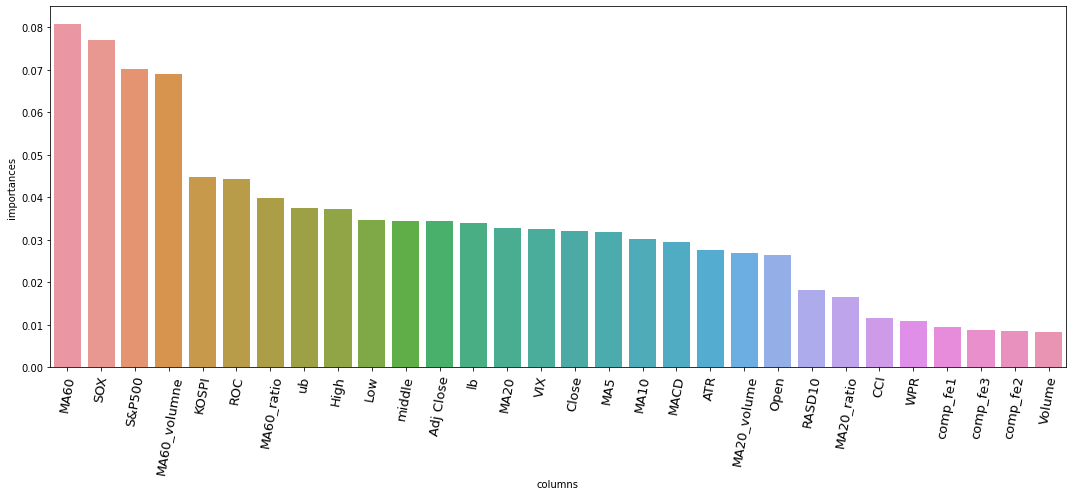

In [ ]:
feature_importance(forest)

# voting

In [ ]:
report(voting)

NotFittedError: ignored

# DT

In [ ]:
report(tree)

In [ ]:
feature_importance(forest)

# LGBM

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       181
           1       0.96      0.96      0.96       292

    accuracy                           0.95       473
   macro avg       0.95      0.95      0.95       473
weighted avg       0.95      0.95      0.95       473

Random Forest Accuracy: 0.9492600422832981


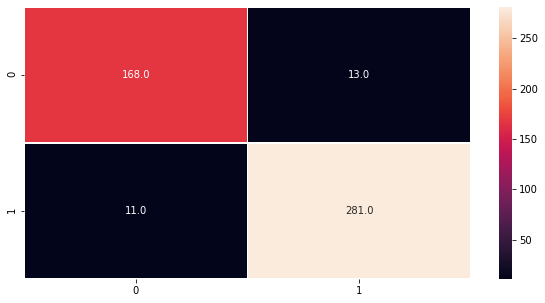

In [ ]:
report(lgb)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


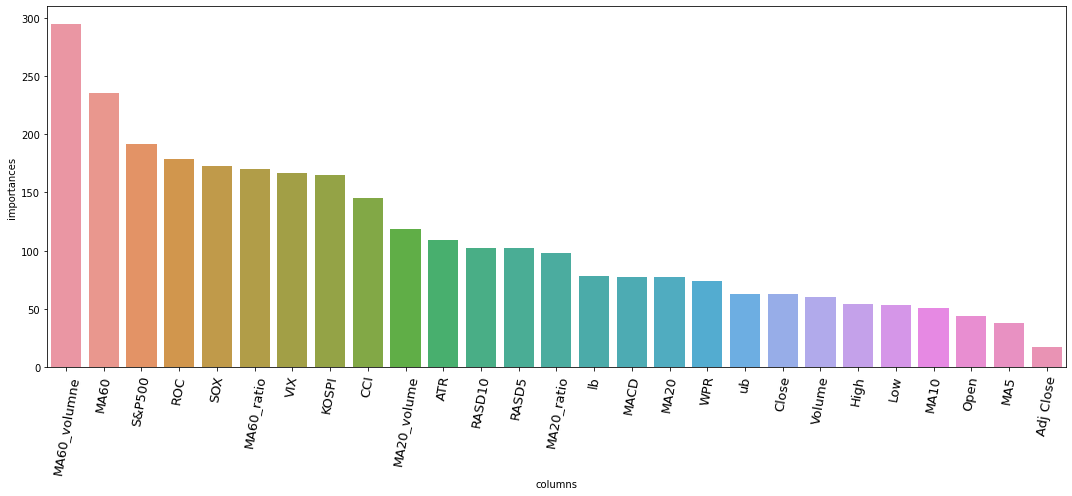

In [ ]:
feature_importance(lgb)

#XGB

In [ ]:
report(xgb)

In [ ]:
feature_importance(xgb)

# ADA

In [ ]:
report(adaboost)

In [ ]:
report(adaboost)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


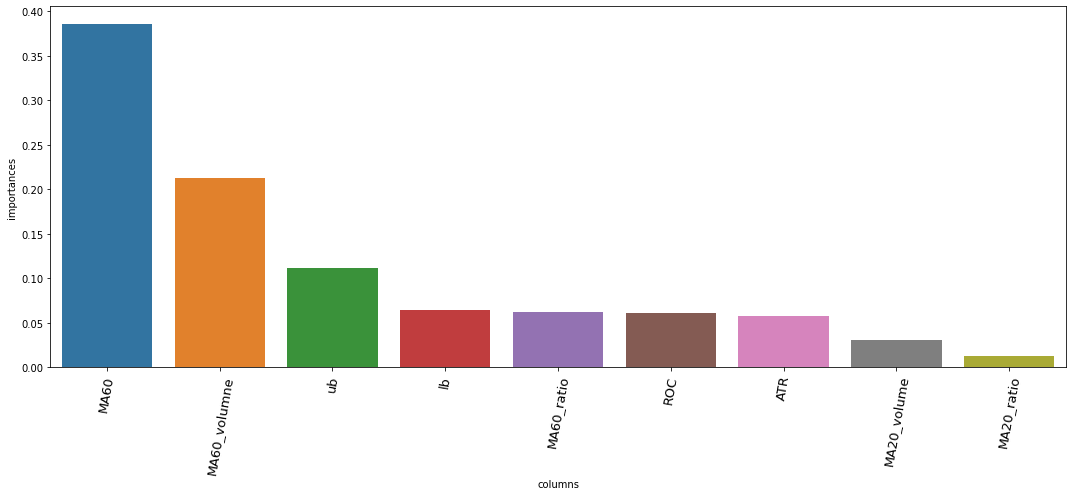

In [ ]:
feature_importance(adaboost)